# Seminar 3: CTC Forward-Backward and Greedy Decoder

The goal of this seminar is to implement the CTC Forward-Backward algorith for Soft-Alignment and Greedy Decoder

In [ ]:
!pip install arpa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%capture
!pip install wandb -qqq

In [ ]:
# comment out if needed
!mkdir week_05_files
!wget -O week_05_files/utils.py https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/utils.py
!wget -O week_05_files/test_matrix.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/test_matrix.txt
!wget -O week_05_files/soft_alignment.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/soft_alignment.txt
!wget -O week_05_files/test_decode.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/test_decode.txt
!wget -O week_05_files/test_labels.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/test_labels.txt
!wget -O week_05_files/3-gram.pruned.1e-7.arpa -q https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/3-gram.pruned.1e-7.arpa

--2022-10-03 15:07:00--  https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_05/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6770 (6.6K) [text/plain]
Saving to: ‘week_05_files/utils.py’

week_05_files/utils 100%[===================>]   6.61K  --.-KB/s    in 0s      

2022-10-03 15:07:01 (41.5 MB/s) - ‘week_05_files/utils.py’ saved [6770/6770]



In [ ]:
#!L
import math
import os
import shutil
import string
import time
from collections import defaultdict
from typing import List, Tuple, TypeVar, Optional, Callable, Iterable

import arpa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import wandb
from matplotlib.colors import LogNorm
from torch import optim
from tqdm.notebook import tqdm
import week_05_files.utils as utils   # Change relative path if needed

## Tokenizer Class

In [ ]:
# Helper functions
BLANK_SYMBOL = "_"

class Tokenizer:
    """
    Maps characters to integers and vice versa
    """
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for i, ch in enumerate(["'", " "] + list(string.ascii_lowercase) + [BLANK_SYMBOL]):
            self.char_map[ch] = i
            self.index_map[i] = ch
        
    def text_to_indices(self, text: str) -> List[int]:
        return [self.char_map[ch] for ch in text]

    def indices_to_text(self, labels: List[int]) -> str:                                                                                                                                                                                                                                 
        return "".join([self.index_map[i] for i in labels])
    
    def get_symbol_index(self, sym: str) -> int:
        return self.char_map[sym]
    

tokenizer = Tokenizer()

NEG_INF = -float("inf")


def logsumexp(*args) -> float:
    """
    Log-sum-exp trick for log-domain calculations
    See for details: https://en.wikipedia.org/wiki/LogSumExp
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max) for a in args))
    return a_max + lsp


def modify_sequence(sequence: List[int], blank_idx: int) -> List[int]:
    """
    Modifies sequence which with START, END blanks and between each character
    """
    modified_sequence = []
    
    for idx in sequence:
        modified_sequence += [blank_idx, idx]
        
    modified_sequence.append(blank_idx)
    return modified_sequence

In [ ]:
tokenizer = Tokenizer()

## Obtain Soft-Alignment via CTC Forward-Backward Algorithm (8 points)

Use your newfound knowledge of the CTC forward-backward algorithm to obtain a soft-alignment

Remember, that the forward variable is computed as follows:

$$
  \begin{aligned}
    &\alpha_t(0) = 0, \forall t & \\
    &\alpha_1(1) = {\tt P}(z_1 = \epsilon | \mathbf{X}_{1:T}), &\\
    &\alpha_1(2) = {\tt P}(z_1 = \omega^{'}_2 | \mathbf{X}_{1:T}), &\\
    &\alpha_1(s) = 0,\ \forall s > 2 &\\
    &\alpha_t(s) = 0,\ \forall s < (2L+1) -2(T-t) -1 &  \text{top right zeros}\\
    &\alpha_t(s) = \left \{
  \begin{aligned}
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) \big) {\tt P}(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s-2}^{'} \\
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) + \alpha_{t-1}(s-2)\big) {\tt P}(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$

Backward Variable is computeed like so:

$$
  \begin{aligned}
    &\beta_T(2L+1) = 1 &\\
    &\beta_T(2L) = 1 & \\
    &\beta_T(s) = 0, \forall s < 2L &\\
    &\beta_t(s) = 0,\ \forall s > 2t &\\
    &\beta_t(2L+2) = 0,\ \forall t  & \text{Bottom left zeros} \\
    &\beta_t(s) = \left \{
  \begin{aligned}
    &\big(\beta_{t+1}(s) + \beta_{t+1}(s+1) \big) {\tt P}(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s+2}^{'} \\
    &\big(\beta_{t+1}(s) +\beta_{t+1}(s+1) + \beta_{t+1}(s+2)\big) {\tt P}(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$

The alignment is then given as:

$$
  \text{align}_t(s) = \frac{\alpha_t(s)\beta_t(s)}{\sum_{s}\alpha_t(s)\beta_t(s)}
$$


Doing the computation in Probability space can be numerically unstable, so you should do it in Log-Space using the
provided logsumexp operation. Remember to return to prob space at the end. You should get something like:

<img src="alignment.png">

If you convert the alignment to log-space it will look like:

<img src="alignment_log.png">

In [ ]:
#!L

def forward_algorithm(sequence, matrix, blank=28):
    # Matrix is has shape [K, T]

    # Turn probs into log-probs
    matrix = np.log(matrix)

    # Create modified sequence which with START, END blanks and between each character
    mod_sequence = [sequence[int((i-1)/2)] if i % 2 !=0 else blank for i in range(len(sequence)*2+1)]
    

    # Initialze
    alphas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            #First Step
            alphas[0][t] = ...
            alphas[1][t] = ...
                
            # Diagonal zeros
            elif <Cond>:
                continue
                
            else:
                # Need to do this stabily
                if s == 0:
                    alphas[s][t] = ... 

                elif s == 1:
                    alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[...][...] 
                    
                else:
                    if mod_sequence[s] == blank or mod_sequence[s] == mod_sequence[s - 2]:
                        alphas[s][t] = logsumexp(...)+matrix[...][...] 
                    else:
                        alphas[s][t] = logsumexp(...)+matrix[...][...] 
    return alphas

In [ ]:
def backward_algorithm(sequence, matrix, blank=28):
    # Matrix has shape [K, T] where K - 29 

    # Turn probs into log-probs
    matrix = np.log(matrix)

    # Create modified sequence which with START, END blanks and between each character
    mod_sequence = [sequence[int((i-1)/2)] if i % 2 !=0 else blank for i in range(len(sequence)*2+1)]

    betas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            #First Step
            if t == matrix.shape[1]-1:
                betas[len(mod_sequence)-1][t] = 0
                betas[len(mod_sequence)-2][t] = 0
            #Diagonal Zeros
            elif <cond>:
                continue
            else:
                if s == len(mod_sequence)-1:
                    betas[s][t] = ... 

                elif s == len(mod_sequence)-2:
                    betas[s][t] = logsumexp(...) + matrix[...][...] 

                else:
                    if mod_sequence[s] == blank or mod_sequence[s] == mod_sequence[s + 2]:
                        betas[s][t] = logsumexp(...) + matrix[...][...] 
                    else:
                        betas[s][t] = logsumexp(...) + matrix[...][...] 
    return betas

In [ ]:
def soft_alignment(labels_indecies, matrix):
    alphas = forward_algorithm(labels_indecies, matrix)
    betas = backward_algorithm(labels_indecies, matrix)


    # Move from log space back to prob space
    align = np.exp(...)

    # Normalize Alignment
    align = ...

    return align

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


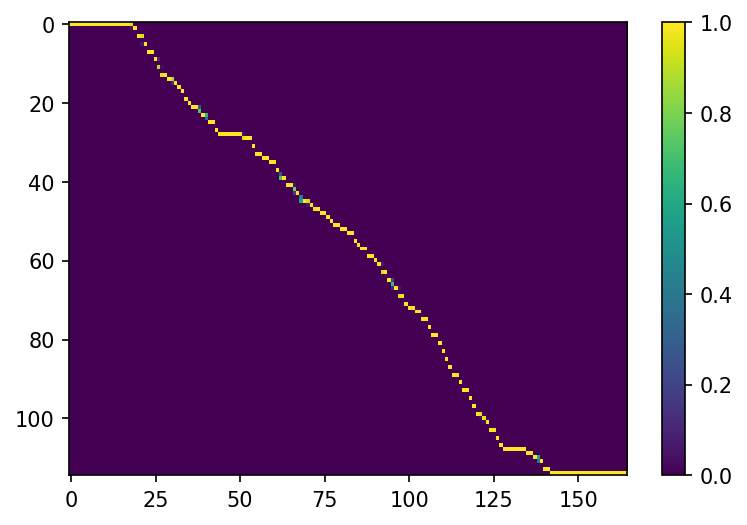

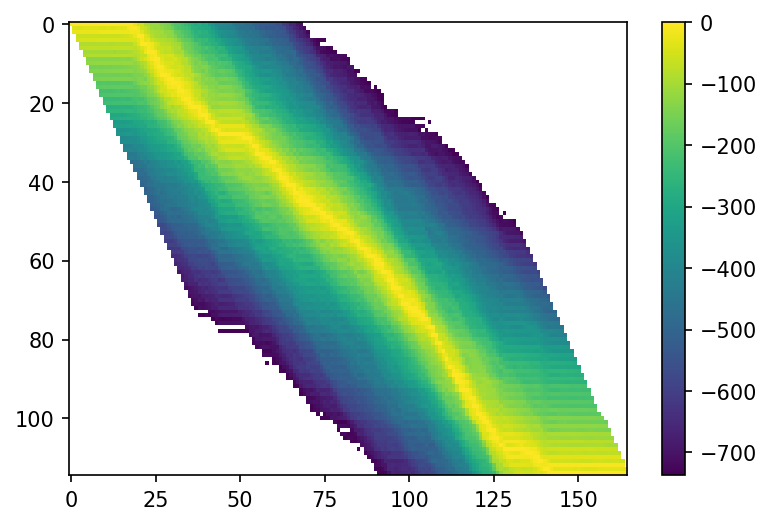

In [ ]:
#!l
# Test your implementation

#Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt('week_05_files/test_matrix.txt')
# Create label_sequence
labels_indecies = tokenizer.text_to_indices('there se ms no good reason for believing that twillc ange')

align = soft_alignment(labels_indecies, matrix)

plt.figure(dpi=150)
plt.imshow(align, aspect='auto', interpolation='nearest')
plt.colorbar()


plt.figure(dpi=150)
plt.imshow(np.log(align), aspect='auto', interpolation='nearest')
plt.colorbar()


ref_align = np.loadtxt('week_05_files/soft_alignment.txt')

assert np.allclose(ref_align, align)

## Implement a Greedy Best-Path Decoder! (2 points)

Your goal is to implement a Greedy Best-Path decoder. Remember than in CTC the joint distribution over states factors out into a product of marginals:

$${\tt P}(\mathbf{z}_{1:T}|\mathbf{X}_{1:T},\mathbf{\theta}) = \prod_{1:T}^T{\tt P}(z_t|\mathbf{X}_{1:T},\mathbf{\theta})$$

Mostly likely state sequence is:

$$\mathbf{\pi}^*_{1:T} = \arg \max_{\mathbf{pi}_{1:T} } \prod_{t=1}^T {\tt P}(z_t = \pi_t|\mathbf{X}_{1:T})$$

Then merge repeats and remove blanks.

In [ ]:
#!L
def GreedyDecoder(output: torch.Tensor, labels: list, label_lengths: list, blank_label=28, collapse_repeated=True):
    """ist
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: Listof torch.Tensor of label indecies
    :param label_lengths:  int of label lengths
    :param blank_label:
    :param collapse_repeated:
    :return: 
    """

    # Get max class
    arg_maxes = np.argmax(output, axis=-1)

    decodes = []
    targets = []

    
    for i, args in enumerate(arg_maxes):
        decode = []

        targets.append(tokenizer.indecies_to_text(labels[i][:label_lengths[i]].tolist()))

        # Remove repeeats, then remove blanks

        for j, index in enumerate(args):
            if <cond>:
                if collapse_repeated and <cond>:
                    continue
                decode.append(index.item())
        decodes.append(tokenizer.indecies_to_text(decode))
    return decodes, targets

In [ ]:
#!L
# TESTING THE GREEDY DECODER

#Load numpy matrix, add axis [batch,classes,time]
matrix = np.loadtxt('week_05_files/test_matrix.txt')[np.newaxis,:,:]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1,2)

# Create list of torch tensor
labels_indecies = [torch.Tensor(tokenizer.text_to_indices('there seems no good reason for believing that it will change'))]

# Run the Decoder
decodes, targets = GreedyDecoder(matrix, labels_indecies, [len(labels_indecies[0])])

assert decodes[0] == 'there se ms no good reason for believing that twillc ange'
assert targets[0] == 'there seems no good reason for believing that it will change'